In [1]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms as transforms
from sklearn.manifold import TSNE

In [2]:
# user modules
import sys
import os
from os import path
sys.path.append(path.dirname(path.abspath('')))
from models.wideresnet import WideResNet
from models.resnet import ResNet9
from metrics.similarity import *
from data.partition import partition_data, get_partition_dict
from data.datasets import load_cifar10_data
from data.dataloader import get_dataloader

In [3]:
def find_ckpt(expname, comm, modeldir='../ckpt', epoch=None, client=None):
    f = filter(lambda x: expname in x, os.listdir(modeldir))
    f = filter(lambda x: f'comm{comm:03}' in x, f)
    if client is None:
        f = filter(lambda x: f'GLOBAL' in x, f)
    else:
#         f = filter(lambda x: f'epoch{epoch:03}' in x, f)
        f = filter(lambda x: f'CLIENT{client:02}' in x, f)
    return list(f)[0]

In [4]:
modeldir = '../ckpt'
expname = 'RES9-IID'
clientnum = 0

In [25]:
client = ResNet9(3, 10)
client.load_state_dict(torch.load(
    os.path.join(modeldir, find_ckpt(expname, comm=1, client=clientnum, modeldir=modeldir))
))
global_ = ResNet9(3, 10)
global_.load_state_dict(torch.load(
    os.path.join(modeldir, find_ckpt(expname, comm=1, modeldir=modeldir))
))

<All keys matched successfully>

In [26]:
net_dataidx_map = get_partition_dict('cifar10', 'homo', 10, datadir='~/data', init_seed=0)
_, _, trainset, testset= get_dataloader(
    'cifar10', '~/data', 128, 32,
    net_dataidx_map[0], 0, 
)

In [27]:
def extract_repr(model, dataset, n_samples=256):
    reprs = []
    def hook(module, input_):
        reprs.append(input_)

    model.layer1.register_forward_pre_hook(hook)
    model.layer2.register_forward_pre_hook(hook)
    model.layer3.register_forward_pre_hook(hook)
    model.classifier.register_forward_pre_hook(hook)

    with torch.no_grad():
        model(torch.stack([data for data, target in dataset][:256]), )
    return [rep[0].view(rep[0].shape[0], -1) for rep in reprs]

In [28]:
repr_client = extract_repr(client, testset)
repr_global = extract_repr(global_, testset)

In [29]:
result = np.zeros((len(repr_client), len(repr_global)))

In [30]:
i=0
for r_a in repr_client:
    j=0
    for r_b in repr_global:
        result[i,j] = kernel_CKA(r_a, r_b)
        j+=1
    i+=1

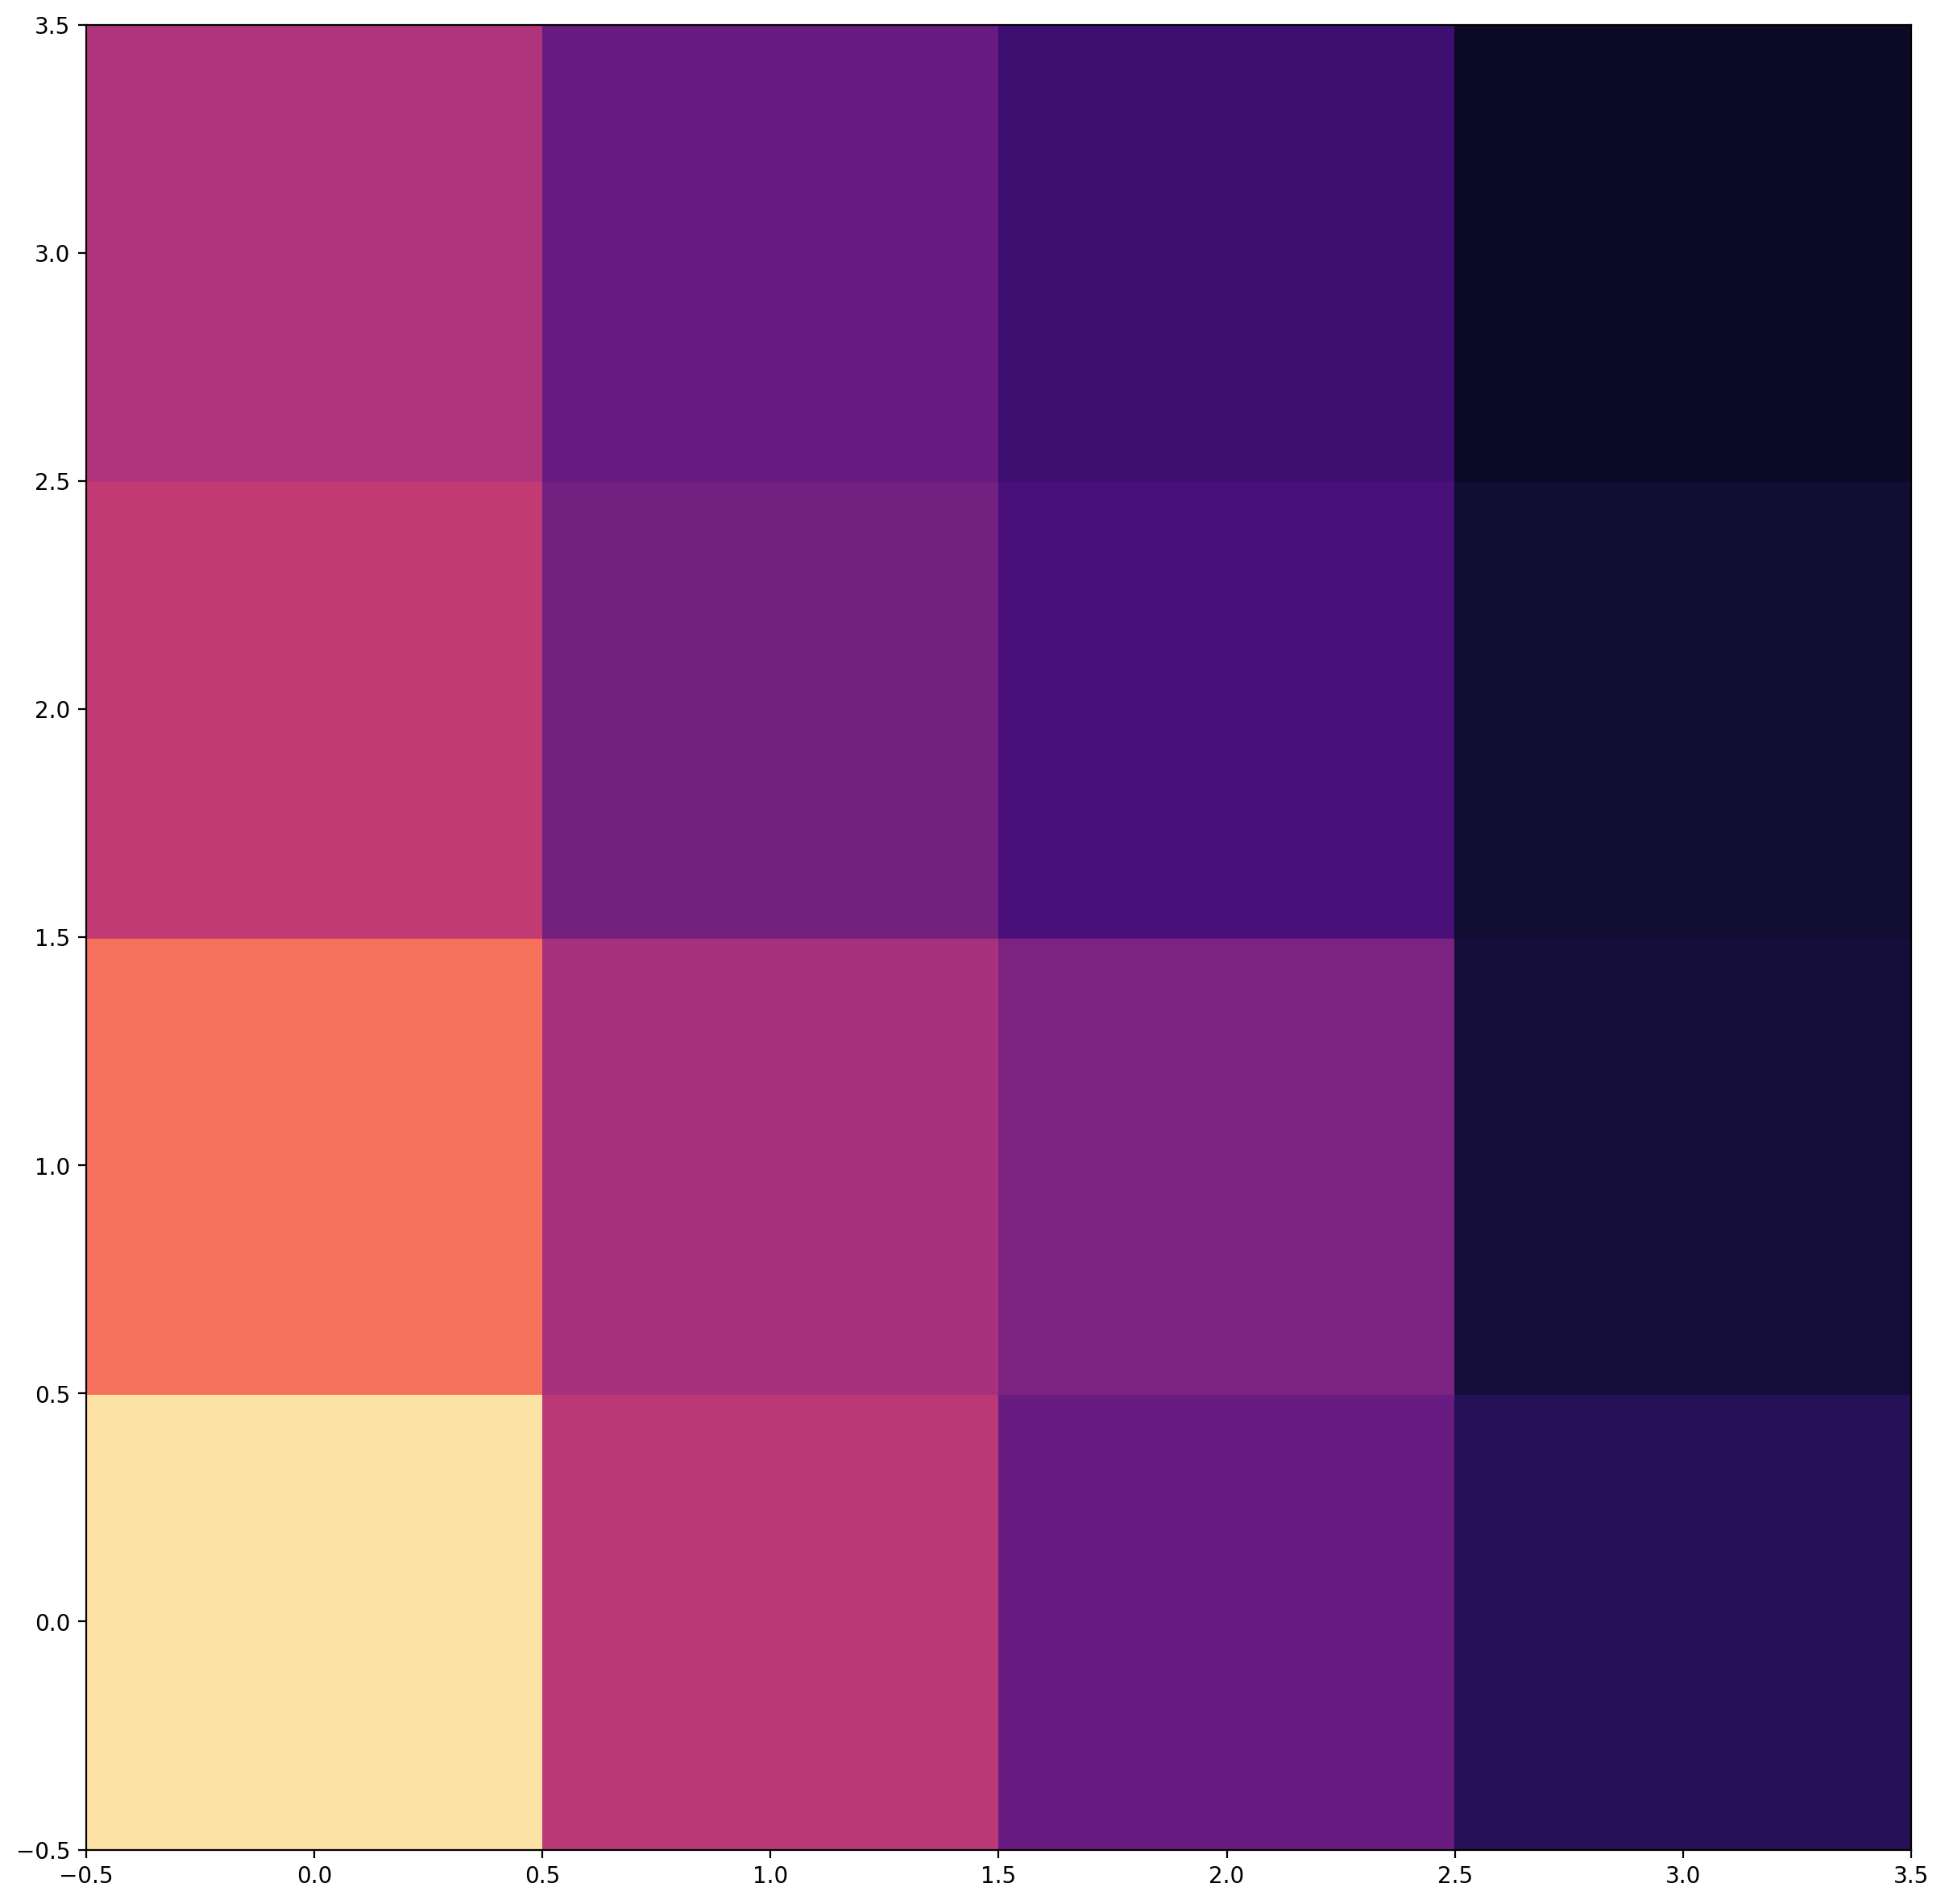

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(result, cmap='magma', vmin=0.0,vmax=1.0)
axes.axes.invert_yaxis()
# plt.savefig("/content/comparison.png", dpi=400)

In [41]:
# For partition check

# _, y_train, _,_ = load_cifar10_data('~/data')
# net_cls_counts = {}
# for net_i, dataidx in net_dataidx_map.items():
#     unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
#     net_cls_counts[net_i] = {unq[i]: unq_cnt[i] for i in range(len(unq))}
# net_cls_counts

In [ ]:
net_dataidx_map = get_partition_dict(
    'cifar10', 'noniid-labeldir', 10, datadir='~/data', init_seed=0,
    beta=0.5
)